# Random Forest

## Import Data

In [1]:
import numpy as np
import pandas as pd

train_df = pd.read_parquet("../data/train_non_lin_preprocessed.parquet")
print(train_df.shape)

X_train = train_df.drop(columns = ['target'])
y_train = train_df['target']

test_df = pd.read_parquet("../data/test_non_lin_preprocessed.parquet")
print(test_df.shape)

X_test = test_df.drop(columns = ['target'])
y_test = test_df['target']

(1076248, 80)
(269062, 80)


## Imbalanced Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

target_col = "target"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Test ROC AUC: 0.7207610799635567
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    215350
           1       0.58      0.06      0.12     53712

    accuracy                           0.80    269062
   macro avg       0.69      0.53      0.50    269062
weighted avg       0.76      0.80      0.74    269062



In [ ]:
def plot_feature_importances(rf):

    importances = rf.feature_importances_
    feature_names = X_train.columns

    # Sort by importance
    sorted_idx = importances.argsort()[::-1]

    plt.figure(figsize=(10,5))
    plt.bar(range(len(importances)), importances[sorted_idx])
    plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
    plt.title("Feature Importance")
    plt.show()

plot_feature_importances(rf_model)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Balanced Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Test ROC AUC: 0.7159379742636198
              precision    recall  f1-score   support

           0       0.87      0.72      0.79    215350
           1       0.34      0.59      0.43     53712

    accuracy                           0.69    269062
   macro avg       0.61      0.65      0.61    269062
weighted avg       0.77      0.69      0.72    269062



In [ ]:
plot_feature_importances(rf_model)

Note that this gives a similar ROC AUC, but is much better on the positive class.

## Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import StratifiedKFold, GridSearchCV

# rf_model = RandomForestClassifier(
#     n_estimators=25,
#     random_state=42,
#     n_jobs=-1,
#     class_weight='balanced'  # Handle imbalance
# )

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# param_grid = {
#     'max_depth': [10, 20],  # None = expand fully
#     'max_features': ['sqrt', 'log2'], # features per split
#     'min_samples_split': [5, 10]   # control overfitting
# }

# grid_search = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid,
#     scoring='roc_auc',  # optimize for AUC
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5}
Best ROC AUC: 0.7165833109563081


In [ ]:
# from sklearn.metrics import roc_auc_score

# best_rf = grid_search.best_estimator_
# y_proba = best_rf.predict_proba(X_test)[:, 1]
# print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

Test ROC AUC: 0.716935230809707


In [ ]:
# plot_feature_importances(best_rf)

# XGBoost

In [77]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb_model = xgb.XGBClassifier(
    n_estimators=400,        # number of trees
    max_depth=5,            # depth of trees
    learning_rate=0.1,       # shrinkage
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    eval_metric='auc',       # track ROC AUC
    tree_method='gpu_hist',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_proba = xgb_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print("XGBoost ROC AUC:", auc_score)

scale_pos_weight: 4.00936945826565


c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:28:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:2676: UserWarning: [19:28:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


XGBoost ROC AUC: 0.7352468432020971


In [32]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

PR AUC: 0.40681454972520753


In [75]:
import numpy as np

cost_fn = 10  # relative cost
cost_fp = 1

thresholds = np.linspace(0, 1, 101)
best_threshold, best_cost = 0, float('inf')

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    FN = np.sum((y_test==1) & (y_pred==0))
    FP = np.sum((y_test==0) & (y_pred==1))
    cost = FN*cost_fn + FP*cost_fp
    
    if cost < best_cost:
        best_cost = cost
        best_threshold = t

print("Best threshold:", best_threshold)
print("Min expected cost:", best_cost)

Best threshold: 0.29
Min expected cost: 188056


In [78]:
y_pred = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred))
print()

y_pred = (y_proba >= 0.45).astype(int) # 5:1 cost_fn:cost_fp
print(classification_report(y_test, y_pred))
print()

y_pred = (y_proba >= 0.29).astype(int) # 10:1 cost_fn:cost_fp
print(classification_report(y_test, y_pred))
print()

y_pred = (y_proba >= 0.18).astype(int) # 20:1 cost_fn:cost_fp
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.66      0.76    215350
           1       0.33      0.68      0.45     53712

    accuracy                           0.66    269062
   macro avg       0.61      0.67      0.60    269062
weighted avg       0.78      0.66      0.70    269062


              precision    recall  f1-score   support

           0       0.91      0.57      0.70    215350
           1       0.31      0.76      0.44     53712

    accuracy                           0.61    269062
   macro avg       0.61      0.67      0.57    269062
weighted avg       0.79      0.61      0.65    269062


              precision    recall  f1-score   support

           0       0.95      0.30      0.45    215350
           1       0.25      0.93      0.39     53712

    accuracy                           0.42    269062
   macro avg       0.60      0.61      0.42    269062
weighted avg       0.81      0.42      0.44    269062


              pr

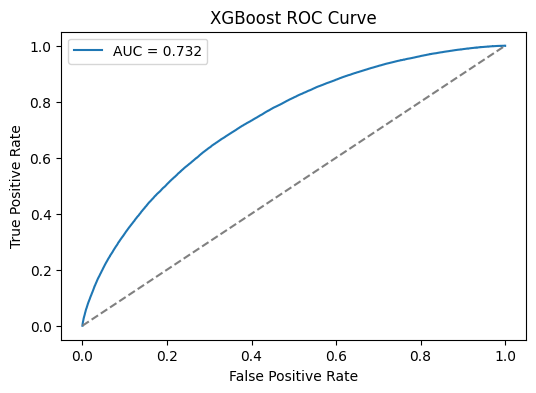

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()

XGBoost is too computationally intense to tune hyperparameters.